# Better identification

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Reference design and training & testing datasets generation

In [5]:
a = rnd.uniform(low=-1,high=1,size=(2,4))
print(a)

[[-0.87398  0.25426 -0.88021  0.94229]
 [ 0.62723  0.36429 -0.48815 -0.29944]]


(2, 1000, 1)


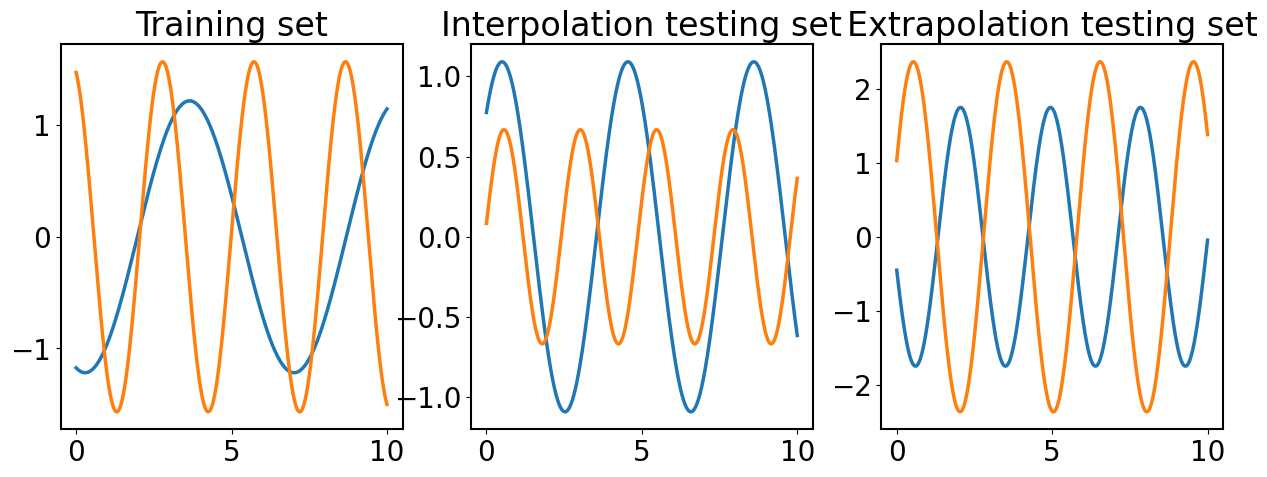

In [149]:
train_demo = 1
test_demo = 12
nb_demo = train_demo + test_demo
N = 10000
dt = 1e-2
pi = np.pi
x_dim = 2

t = np.linspace(0, dt*N, N)[None][...,None]
###########################################################################################################
A_train = np.random.uniform(low=-pi/2, high=pi/2, size=(train_demo,x_dim//2))[:, None]

A_test_ext = np.concatenate([
    np.random.uniform(low=-pi+0.01, high=-pi/2, size=(test_demo//4,x_dim//2))[:, None],
    np.random.uniform(low=pi/2, high=pi-0.01, size=(test_demo//4,x_dim//2))[:, None]
],0)

A_test_int = np.random.uniform(low=-pi/2, high=pi/2, size=(test_demo//2,x_dim//2))[:, None]

A = np.concatenate([A_train, A_test_int, A_test_ext], 0)
###########################################################################################################

phi = np.random.uniform(low=-pi, high=pi, size=(nb_demo,x_dim//2))[:, None]
###########################################################################################################

f = np.random.uniform(low=0.1, high=0.4, size=(nb_demo,x_dim//2))[:, None]

w = 2*pi*f
###########################################################################################################

x_train = A_train*np.cos(w[:A_train.shape[0]]*t+phi[:A_train.shape[0]])

x_test_int = A_test_int*np.cos(1.1*w[A_train.shape[0]:A_train.shape[0]+test_demo//2]*t+phi[A_train.shape[0]:A_train.shape[0]+test_demo//2])

x_test_ext = A_test_ext*np.cos(w[A_train.shape[0]+test_demo//2:]*t+phi[A_train.shape[0]+test_demo//2:])
###########################################################################################################

fig,ax = plt.subplots(ncols=3, figsize=(15,5))
for x_train_, x_test_1, x_test_2  in zip(x_train, x_test_int, x_test_ext):
    _ = ax[0].plot(t[0],x_train_)
    _ = ax[1].plot(t[0],x_test_1)
    _ = ax[2].plot(t[0],x_test_2)

ax[0].set_title("Training set")
ax[1].set_title("Interpolation testing set")
ax[2].set_title("Extrapolation testing set")
print(x_train.shape)

In [ ]:
# Simple sinusoids ###################################################    
# time = np.arange(0,20,dt)
# pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(70),0]), dt=dt)
# pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(120),0]), dt=dt)
# # # Reference design
# freq1, freq2 = .125, .125
# pend1.T_ref, pend2.T_ref = 1/freq1/pend1.dt, 1/freq2/pend2.dt
# amplitude1, amplitude2 = 40, 50 # deg
# pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 70)
# pend2.ref = sineReference(pend2.N, pend1.dt, pend2.T_ref, amplitude2, 120)

# for i in range(pend1.N-1):
#     if i <= pend1.N:
#         Kp, Ki, Kd = 70, 1, 5
#     else:
#         Kp, Ki, Kd = 10, 2.5, 5
#     pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 80, limit=200)[0]
#     pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
#     pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 90, 11, 25, pend2.dt, 40, limit=200)[0]
#     pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
ref1 = varSine([30,50,80,100,140], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [0,0,0,0,0], dt)
ref2 = varSine([30,50,80,50,10], [.5,.5,.5,.5,.5], 4*np.array([1,1,1,1,1]), [60,80,90,100,100], dt)

time = np.arange(0,len(ref1)*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
pend1.ref, pend2.ref = ref1, ref2

for i in range(pend1.N-1):
    if i <= pend1.N:
        Kp, Ki, Kd = 50, 20, 5
    else:
        Kp, Ki, Kd = 10, 2.5, 5
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=200)[0] 
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend2.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()
ax[0,0].set_title('Reference for training'), ax[0,1].set_title('Reference for testing')

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend2.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend2.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()


## Creating a nasty sine-ish reference

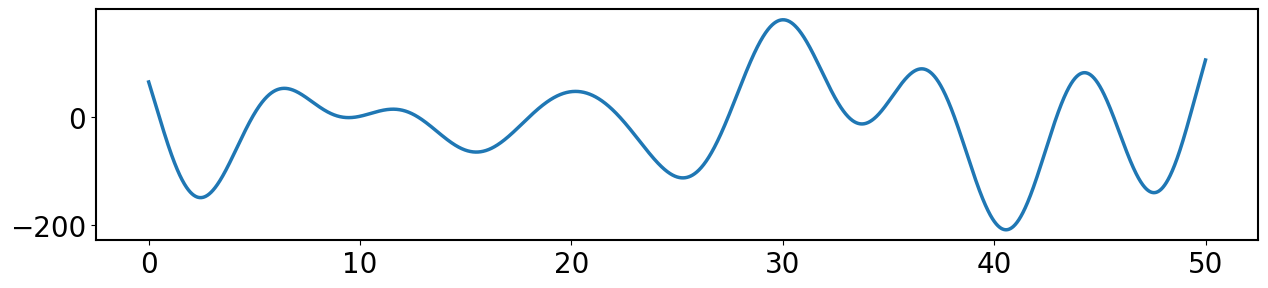

In [165]:
###############################
N = 5000
dt = 1e-2
pi = np.pi
nb_parts = 100
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_train = 0
for i in range(nb_parts):
    x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_train = x_train/max(x_train)*pi
pend1.ref = x_train
###############################
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(t,rad2deg(x_train))

## Simulate with nasty sine to retrieve training set

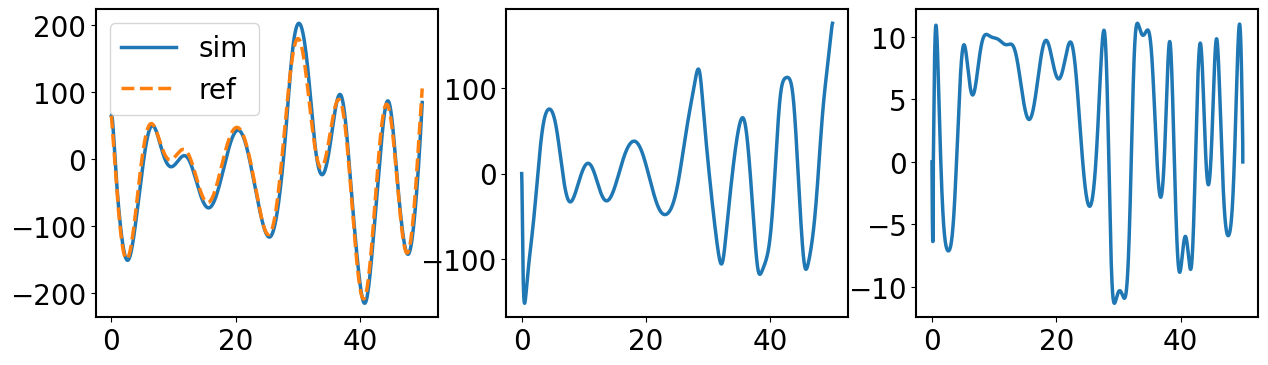

In [166]:
Kp, Ki, Kd = 50, 20, 5
U_train = np.zeros(shape=[N])
X_train = np.zeros(shape=[2,N])
X_train[0,0] = x_train[0]
##############################################
for i in range(N-1):
    U_train[i] = PID(X_train, i, x_train[i], Kp, Kd, Ki, pend1.dt, 20, limit=[-20,20])[0] 
    X_train[:,i+1] = RK4(pend1.dynamics, X_train[:,i], U_train[i], pend1.dt, type='controller-step-by-step')
#         pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 60, 11, 25, pend2.dt, 40, limit=200)[0]
#         pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
pend1.X = X_train
pend1.U = U_train
##############################################
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

ax[0].plot(t,rad2deg(X_train[0,:]),label='sim'), ax[0].plot(t,rad2deg(x_train),linestyle='dashed',label='ref'),ax[0].legend()
ax[1].plot(t,rad2deg(X_train[1,:]))
ax[2].plot(t,U_train)

# Observing trajectories in subspace

## First train linear model

In [216]:
tau = 7
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
# horizon = np.int(len(pend.T)*.7)
horizon = 2000
model1.HANKEL(horizon)
model1.SVD(tau)
model1.LS(tau,rcond=0)
model1.Simulate(X_train[:,0], U_testing=pend.U)

## Then observe the trajectories within the subspace

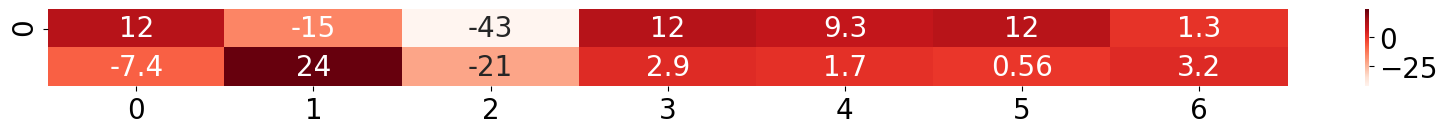

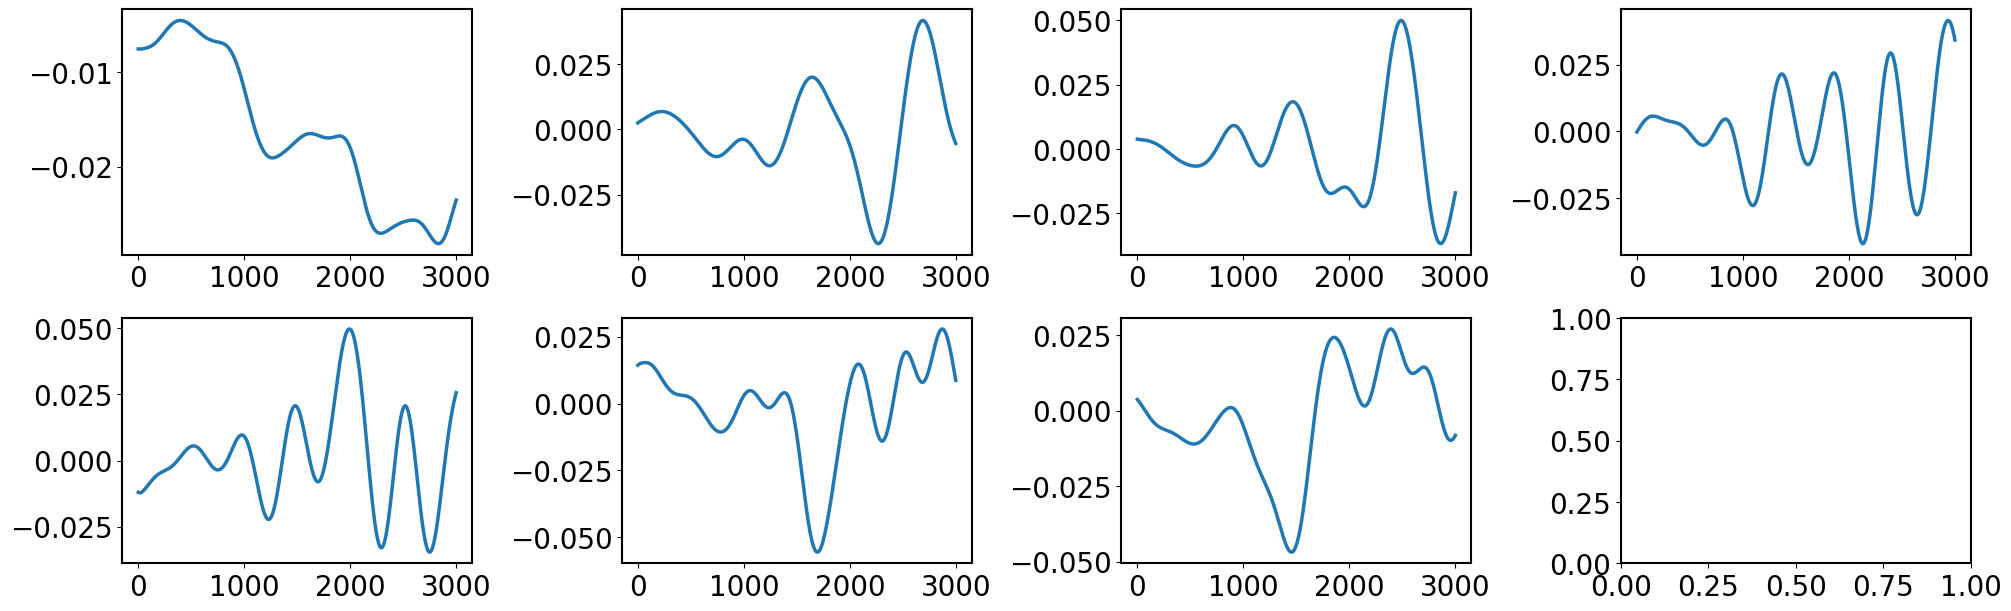

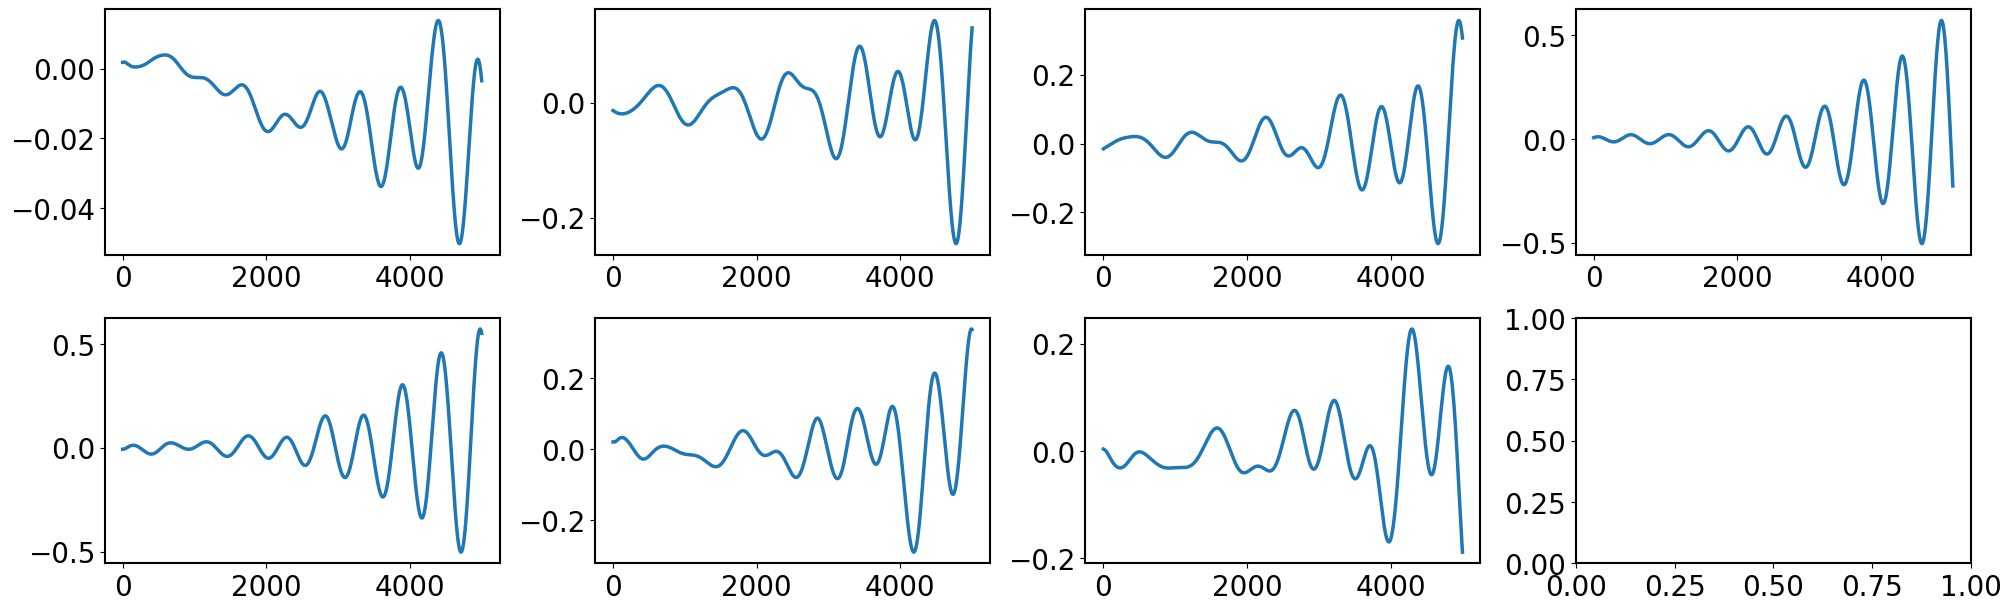

In [217]:
nb_dims = model1.Y.shape[0]

fig1 = plt.figure(figsize=(20,1))
snb.heatmap(model1.C,cmap='Reds',annot=True)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nb_dims//4+1, 4, 
                       constrained_layout = True, figsize=(20,3*(nb_dims//4+1)))

j = -1
for i in range(nb_dims):
    if i%4 == 0: j +=1
    ax[j,i%4].plot(model1.Y[i,:])
    
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(nb_dims//4+1, 4, 
                       constrained_layout = True, figsize=(20,3*(nb_dims//4+1)))

j = -1
for i in range(nb_dims):
    if i%4 == 0: j +=1
    ax[j,i%4].plot(model1.Y_traj[i,:])

## Check what the trajectory really looks like in original space

([<matplotlib.lines.Line2D at 0x227a7d4a8b0>],
 <matplotlib.legend.Legend at 0x227a7d4abe0>)

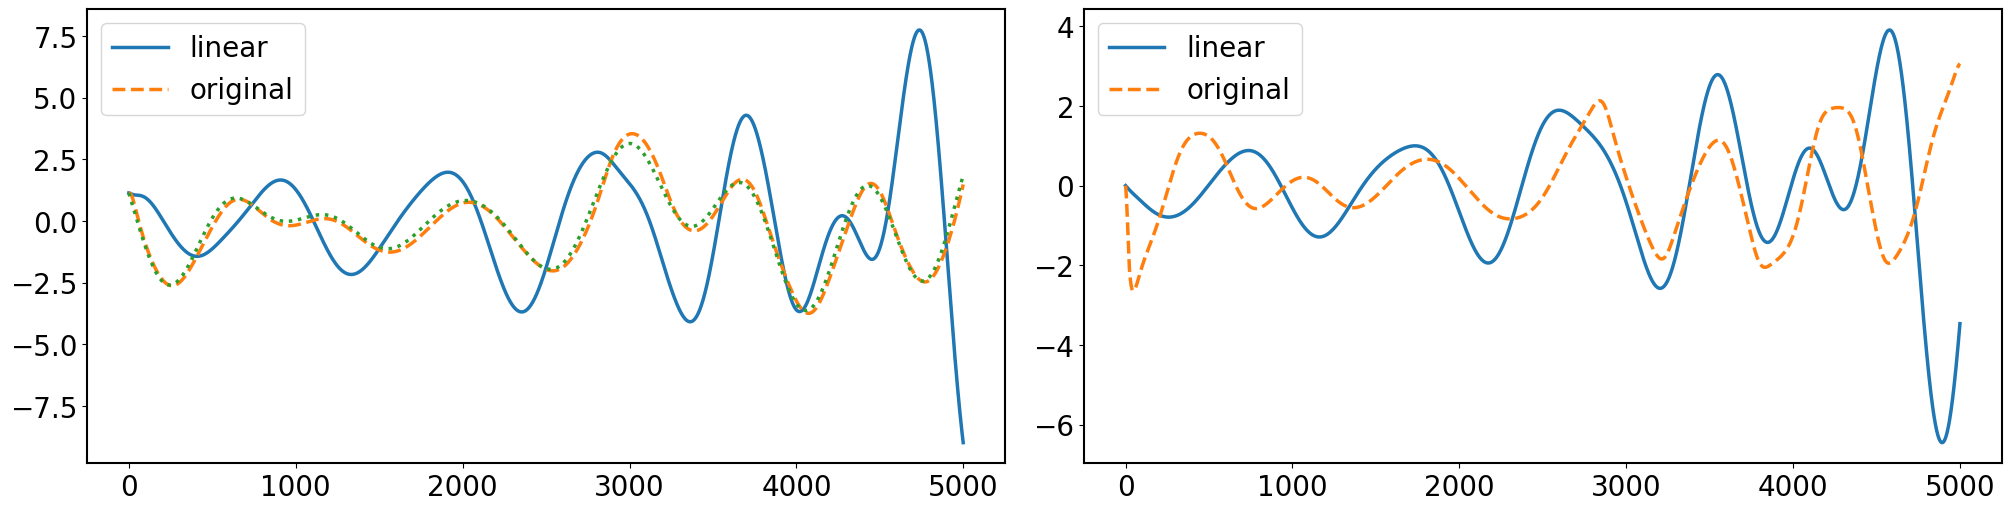

In [218]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
ax[0].plot(pend.X[0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref),linestyle='dotted'), ax[0].legend(), ax[1].legend()